# 数据准备
下载 猫 狗 数据集

In [1]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  10.2M      0  0:01:17  0:01:17 --:--:-- 16.7M


In [2]:
!unzip -q kagglecatsanddogs_3367a.zip

In [3]:
!ls

1_Image_classification_from_scratch.ipynb
Basic_Image_Classification.ipynb
Basic_text_classification.ipynb
MSR-LA - 3467.docx
PetImages
kagglecatsanddogs_3367a.zip
readme[1].txt


In [4]:
!ls PetImages

Cat Dog


# 数据预处理
过滤错误图片

> JPG files contain the string "JFIF" at the beginning of the file, encoded as bytes

In [5]:
import tensorflow as tf

In [7]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10) # convert "JFIF" to bytes; return the first 10 bytes
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


# 生成数据集

In [9]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


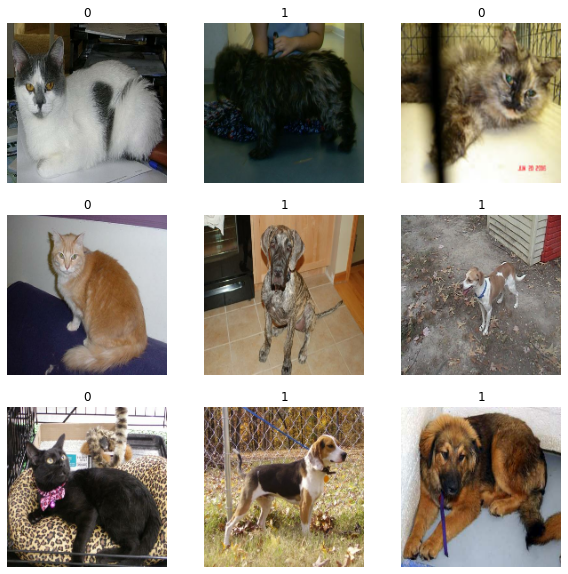

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

# 增强数据集
> When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [15]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1)
    ]
)

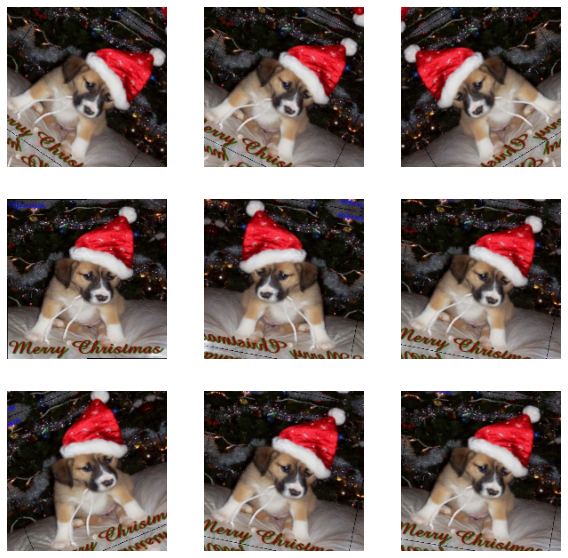

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# 数据标准化

In [18]:
# for GPU， 同步
# inputs = tf.keras.Input()
# x = data_augmentation(inputs)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)

# for CPU, 异步
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [19]:
train_ds = train_ds.prefetch(buffer_size=32) # 预加载
val_ds = val_ds.prefetch(buffer_size=32)

# 建模